In [1]:
import os, shutil
import requests

api_key = ""
start_date = "1960-01-01"
end_date = "2003-12-31"
sort_order = "oldest"
page_size = 20 # articles per page
headers = {
    "api-key": api_key,
    "format": "json"
}

In [3]:
import glob, re
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import matplotlib.pyplot as plt
import string
import multiprocessing

# get all the .txt files in "Plaintexts" directory in list
textfiles = glob.glob(os.path.join("culture", "*.txt"), recursive=False)

# placeholder for all the extracted keywords
combined_keywords = ''

d = []
# loop through the web_pages list
for textfile in textfiles:
    with open(textfile, 'r') as f:
        lines = f.readlines()
        title = lines[0]
        keywords = lines[1] # get keywords (descriptions) on line 2 of every file
        timestamp = lines[2]
        byline = lines[3]
        wordcount = lines[4]
        content = lines[5]
        clean_dups = ','.join(set(keywords.split(',')))
        d.append({'TITLE': title.replace('\n',''), 
                  'KEYWORDS': clean_dups.replace('\n',''), 
                  'TIMESTAMP': timestamp.replace('\n',''), 
                  'BYLINE': byline.replace('\n',''), 
                  'WC': wordcount.replace('\n',''), 
                  'BODYTEXT': content})

news_articles = pd.DataFrame(d)
cached_stop_words = ['Culture']

# Convert date
# pd.to_datetime('13000101', format='%Y%m%d')
# 
news_articles['TIMESTAMP'] = pd.to_datetime(news_articles['TIMESTAMP'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
news_articles['KEYWORDS'] = news_articles['KEYWORDS'].str.split(',').apply(set).str.join(',')
p = re.compile("({})".format(','.join(map(re.escape, cached_stop_words))))
news_articles['KEYWORDS'] = news_articles['KEYWORDS'].str.replace(p, '')
news_articles['WC'] = pd.to_numeric(news_articles['WC'])
news_articles['KEYWORDS'] = news_articles['KEYWORDS'].apply(lambda x: ",".join(filter(None, x.split(','))))
news_articles['KEYWORDS'] = news_articles['KEYWORDS'].apply(lambda x: 'Untagged' if x == '' else x)


# Let's take a look at our interesting columns.
# news_articles[["TITLE", "KEYWORDS", "TIMESTAMP", "BYLINE", "BODYTEXT", "WC"]].head()
news_articles[["TITLE", "KEYWORDS", "BODYTEXT", "WC"]].head()

# mean_len = news_articles['BODYTEXT'].str.len().groupby(news_articles['TIMESTAMP']).mean()
# print(mean_len)
# news_articles['WC'].mean()

,TITLE,KEYWORDS,BODYTEXT,WC
0,Dirty rotten scoundrels,"Media,Television & radio","You'll have heard the stories, the tales of ba...",733
1,"Self Portrait in a Straw Hat, Elizabeth Louise...",Art and design,· View the work online Artist: Elizabeth Louis...,568
2,Watch this,Media,"The Game (David Fincher, 1997) 8.50pm, Sky Pre...",307
3,London Jazz festival: top gigs,Music,"US3 Friday November 9, Forum, Kentish Town NW5...",824
4,Pick of the day: radio,"Media,Television & radio",There was little early evidence that Ludwig va...,234


In [4]:
# https://stackoverflow.com/a/48120674/9510334

def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[["TITLE", "KEYWORDS", "TIMESTAMP", "BYLINE", "BODYTEXT", "WC"]]

def split_df(dataframe, col_name, sep):
    orig_col_index = dataframe.columns.tolist().index(col_name)
    orig_index_name = dataframe.index.name
    orig_columns = dataframe.columns
    dataframe = dataframe.reset_index()  # we need a natural 0-based index for proper merge
    index_col_name = (set(dataframe.columns) - set(orig_columns)).pop()
    df_split = pd.DataFrame(
        pd.DataFrame(dataframe[col_name].str.split(sep).tolist())
        .stack().reset_index(level=1, drop=1), columns=[col_name])
    df = dataframe.drop(col_name, axis=1)
    df = pd.merge(df, df_split, left_index=True, right_index=True, how='inner')
    df = df.set_index(index_col_name)
    df.index.name = orig_index_name
    # merge adds the column to the last place, so we need to move it back
    return change_column_order(df, col_name, orig_col_index)

articles_df = split_df(news_articles, 'KEYWORDS', ',')
articles_df.head()

,TITLE,KEYWORDS,TIMESTAMP,BYLINE,BODYTEXT,WC
0,Dirty rotten scoundrels,Media,2003-05-22 06:29:51,Gareth McLean,"You'll have heard the stories, the tales of ba...",733
0,Dirty rotten scoundrels,Television & radio,2003-05-22 06:29:51,Gareth McLean,"You'll have heard the stories, the tales of ba...",733
1,"Self Portrait in a Straw Hat, Elizabeth Louise...",Art and design,2000-05-27 15:34:09,Jonathan Jones,· View the work online Artist: Elizabeth Louis...,568
2,Watch this,Media,1999-12-03 02:15:36,Paul Howlett and Dave Green,"The Game (David Fincher, 1997) 8.50pm, Sky Pre...",307
3,London Jazz festival: top gigs,Music,2001-11-02 04:41:00,John Fordham,"US3 Friday November 9, Forum, Kentish Town NW5...",824


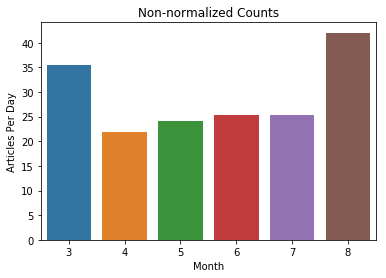

In [5]:
articles_df['MONTH'] = articles_df['TIMESTAMP'].dt.month
articles_df['DAY'] = articles_df['TIMESTAMP'].dt.day

# Some months have 30 and others have 30 days. The first and last months in our dataset and not whole.
month_days = {
    3: 21,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 27
}
articles_per_day = {}
for month in month_days:
    n_articles = len(articles_df[articles_df['MONTH'] == month])
    articles_per_day[month] = n_articles / month_days[month]

ax = sns.barplot(x=list(articles_per_day.keys()), y=list(articles_per_day.values()))
ax.set_title("Non-normalized Counts")
ax.set_xlabel("Month")
ax.set_ylabel("Articles Per Day")
plt.show()

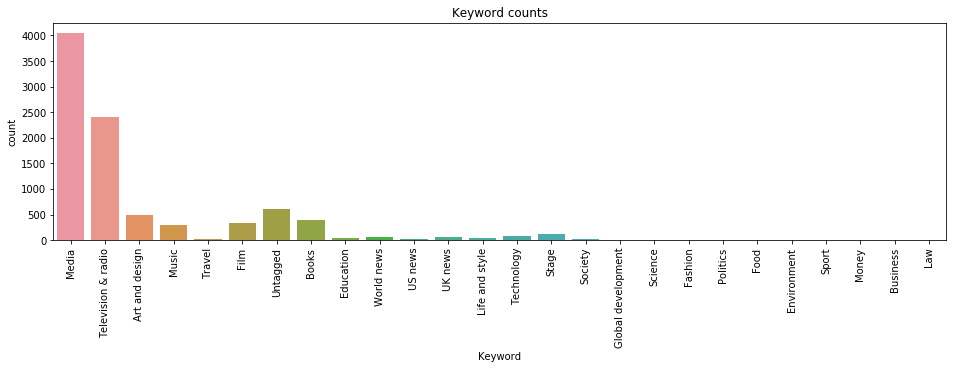

In [6]:
plt.figure(figsize=(16,4))

unqies = (articles_df.KEYWORDS.unique())
inv_descs = {v: v for v in unqies}

keywords_map = inv_descs
ax = sns.countplot(articles_df['KEYWORDS'])
ax.set_title("Keyword counts")
ax.set_xlabel("Keyword")
# Manipulate the labels to make them more readable
ax.set_xticklabels([keywords_map[x.get_text()] for x in ax.get_xticklabels()], rotation=90)
plt.show()

### Exploratory data analysis

In [7]:
def date_printer(date):
    return "{}/{}/{}".format(date.day, date.month, date.year)

start, end = articles_df['TIMESTAMP'].min(), articles_df['TIMESTAMP'].max() 
print("Our dataset timeline starts at {} and ends at {}".format(date_printer(start), date_printer(end)))

Our dataset timeline starts at 17/8/1977 and ends at 31/12/2003


### Keywords

#### Revisit this Antony!

In [8]:
from collections import Counter

# Byte magic to style print output
def emphasize(s):
    """Bold the string to help get the print reader's attention.
    
    Parameters
    ----------
    s : str
        String to be decorated with bold.
    
    Returns
    -------
    str
        The string in bold.
    """
    red = '\x1b[1;31m'
    stop = '\x1b[0m'
    return red + str(s) + stop

# nunique = articles_df['KEYWORDS'].nunique()
nunique = articles_df.index.nunique()
print("There are {} articles. \nMultiple tags can be applied to one article. \nBelow some of the most common tags:".format(emphasize(nunique)))
for key, value in Counter(articles_df['KEYWORDS']).most_common(5):
    print(" {} applied in {} articles".format(emphasize(key), emphasize(value)))

There are 6001 articles. 
Multiple tags can be applied to one article. 
Below some of the most common tags:
 Media applied in 4047 articles
 Television & radio applied in 2400 articles
 Untagged applied in 615 articles
 Art and design applied in 497 articles
 Books applied in 396 articles


### Let's predict

In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def tokenize(s, lemmatize=True, decode=False):
    """ Split a sentence into it's words by removing case sensitivity and stopwords, as well as taking punctuation 
    and other special characters into account.
    
    Parameters
    ----------
    s : str
        The raw string
    lemmatize : bool, optional
        Optionally lemmatize the provided text
    decode : bool, optional
        Whether or not Unicode input that needs to be decoded is expected.
    
    Returns
    -------
    list of str
        The cleaned tokens
        
    """
    # Make sure the NLTK data are downloaded.
    try:
        if decode:
            s = s.decode("utf-8")
        tokens = word_tokenize(s.lower())
    except LookupError:
        nltk.download('punkt')
        tokenize(s)
    

    # Exclude punctuation only after NLTK tokenizer to ensure part of word punctuation is not removed.
    # For example only the second "." should be removed in the below string
    # "Mr. X correctly diagnozed his patient."
    ignored = stopwords.words("english") + [punct for punct in string.punctuation]
    clean_tokens = [token for token in tokens if token not in ignored]
    
    # Optionally lemmatize the output to reduce the number of unique words and address overfitting.
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in clean_tokens]
    return clean_tokens


def test_tokenize():
    """Unit test the tokenizer. """
    
    # With lemmatization
    text = "Mr. X correctly diagnosed his patients."
    expected_result = ['mr.', 'x', 'correctly', 'diagnosed', 'patient']
    assert tokenize(text) == expected_result
    
    # Without lemmatization
    expected_result = ['mr.', 'x', 'correctly', 'diagnosed', 'patients']
    assert tokenize(text, lemmatize=False) == expected_result
    
test_tokenize()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Bag of Words Representation using our own tokenizer.
# vectorizer = CountVectorizer(lowercase=False, tokenizer=tokenize)
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=tokenize)
x = vectorizer.fit_transform(articles_df['BODYTEXT'])

# Create numerical labels.
encoder = LabelEncoder()
y = encoder.fit_transform(articles_df['KEYWORDS'])

# Let's keep this in order to interpret our results later,
encoder_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

# Split into a training and test set. Classifiers will be trained on the former and the final
# results will be reported on the latter.
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=seed)

In [ ]:
# print(vectorizer.get_feature_names())

In [ ]:
def report_accuracy(trained_clf):
    train_score = trained_clf.score(x_train, y_train)
    test_score = trained_clf.score(x_test, y_test)
    print("Training set accuracy score is: {}".format(emphasize(train_score)))
    print("Test set accuracy score is: {}".format(emphasize(test_score)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Let's use all our cores to speed things up.
n_cores = max(multiprocessing.cpu_count(), 1)

rf = RandomForestClassifier(n_jobs=n_cores)
rf.fit(x_train, y_train)
report_accuracy(rf)

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
report_accuracy(clf)

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("culture-articles")

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from pprint import pprint

def print_confusion_matrix(confusion_matrix, class_names, figsize = (14,7), fontsize=14, normalize=False):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap. Based on
    shaypal5's gist: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
        
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylabel('True label')
    heatmap.set_xlabel('Predicted label')
    heatmap.set_title(title)
    return fig

# Get some readable labels
labels = [keywords_map[encoder_mapping[label]] for label in sorted(encoder_mapping.keys())]

conf_mat = confusion_matrix(y_test, clf.predict(x_test), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

ax = print_confusion_matrix(conf_mat, labels, normalize=True)
plt.show()

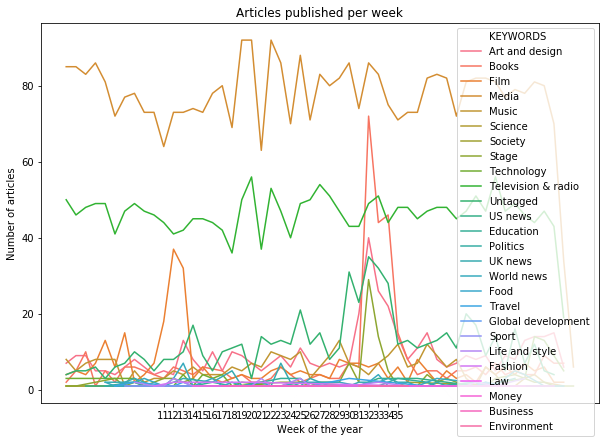

In [118]:
articles_df['WEEK'] = articles_df['TIMESTAMP'].dt.week

# Aggregate by week
aggregated = articles_df[['WEEK', 'MONTH', 'KEYWORDS']]
grouped = aggregated.groupby(['WEEK', 'KEYWORDS']).size().reset_index(name='article_count')
grouped['KEYWORDS'] = grouped['KEYWORDS'].apply(lambda x: inv_descs[x])

plt.figure(figsize=(10, 7))
ax = sns.lineplot(x='WEEK', y='article_count', hue='KEYWORDS', data=grouped, ci=None)
ax.set_xticks(list(range(11, 36)))
ax.set_xlabel("Week of the year")
ax.set_ylabel("Number of articles")
ax.set_title("Articles published per week")
plt.show()

In [119]:
from gensim import corpora
import numpy
import random

# Let's reuse the tokenizer we wrote before to clean the text.
clean_text = articles_df['BODYTEXT'].apply(tokenize)

# Reproducible topics.
numpy.random.seed(seed)
random.seed(seed)

# Create Dictionary and a Corpus (basic Gensim structures)
id2word = corpora.Dictionary(clean_text)
id2word.filter_extremes(no_below=5, no_above=0.05)
print(id2word)
corpus = [id2word.doc2bow(text) for text in clean_text]

Dictionary(33154 unique tokens: ['abandoned', 'adopted', 'advice', 'advising', 'aggie']...)


In [130]:
import gensim
import re

num_topics = 5
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)

# Let's inspect at the discovered topics.
def print_model(model):
    """Print a readable representation of a topic model. 
    
    Parameters
    ----------
    model : gensim.models.ldamodel.LdaModel
        A trained model.  
    """
    def print_topic(topic):
        topic_no, topic_repr = topic
        parts = topic_repr.split("+")
        words = [re.search('"(.*)"', part).group(1) for part in parts]
        return "{}: {}".format(topic_no, words)
    
    for topic in model.print_topics():
        print(print_topic(topic))
        
    
print_model(lda_model)

NameError: name 'corpus' is not defined

In [100]:
for idx, topic in lda_model.show_topics(formatted=False, num_words= 5):
    pprint([idx, [w for w in topic]])

[0,
 [('jazz', 0.0044644214),
  ('piano', 0.002610831),
  ('orchestra', 0.00232459),
  ('musician', 0.00215854),
  ('soprano', 0.0017137851)]]
[1,
 [('mendes', 0.0019729517),
  ('spielberg', 0.0015996259),
  ('conran', 0.0014323328),
  ('guitar', 0.0011443875),
  ('sam', 0.0011250626)]]
[2,
 [('academy', 0.0014590825),
  ('davis', 0.0014395193),
  ('moore', 0.0011995835),
  ('actress', 0.0011552566),
  ('van', 0.0010044889)]]
[3,
 [('tcm', 0.0018832947),
  ('6pm', 0.0018483201),
  ('carlton', 0.0016882258),
  ('romance', 0.0016567877),
  ('allen', 0.0015208726)]]
[4,
 [('museum', 0.0057928977),
  ('iraq', 0.0013744999),
  ('conran', 0.0012220424),
  ('august', 0.0011385345),
  ('heritage', 0.0010564261)]]
[5,
 [('edinburgh', 0.0016812335),
  ('listener', 0.0013503653),
  ('christmas', 0.0012640835),
  ('museum', 0.0010740965),
  ('design', 0.001059452)]]
[6,
 [('museum', 0.002919394),
  ('food', 0.0014282386),
  ('site', 0.0013932126),
  ('minister', 0.001288391),
  ('iraq', 0.00123518

In [129]:
num_topics = 50
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)
# print_model(lda_model)

for idx, topic in lda_model.show_topics(formatted=False, num_words= 10):
    pprint([idx, [w for w in topic]])

NameError: name 'gensim' is not defined

In [104]:
topic_mapping = {i: v for i, (k, v) in enumerate(keywords_map.items())}

unseen_articles = [
    "Artists such as Damien Hirst with his shark (pictured), Gilbert and George and Salvador Dali with his lobster telephone have been immortalised as Lego miniatures. The figures, which are the work of the Little Artists, were unveiled at Art2003, Britain's biggest art fair, which opened yesterday at the Business Design Centre in London.",
    "This list does not aim to be definitive - just to give the UK's main venues for classical music and opera. If you want to get in touch with us to suggest we add your venue or to report a broken link, please email arts.editor@guardianunlimited.co.uk. For London venues click here",
    "Victoria Simmonds, who stars as Rosina in the English National Opera production of The Barber of Seville, meets the construction workers engaged in the extensive restoration of the London Coliseum. They are on the roof of No 6, St Martin's Place with the Coliseum in the background. The Barber of Seville opens tonight."
]

def rank_headline(headline):
    bow_vector = id2word.doc2bow(tokenize(headline))
    lda_vector = lda_model[bow_vector]
    top_topic = topic_mapping[max(lda_vector, key=lambda item: item[1])[0]]
    distribution = {topic_mapping[topic_no]: proportion for topic_no, proportion in lda_vector}
    return top_topic, distribution

for headline in unseen_articles:
    top_topic, distribution = rank_headline(headline)
    print("{}: {} \nTopic Mix: {}\n".format(emphasize(top_topic), headline, distribution))

Film: Artists such as Damien Hirst with his shark (pictured), Gilbert and George and Salvador Dali with his lobster telephone have been immortalised as Lego miniatures. The figures, which are the work of the Little Artists, were unveiled at Art2003, Britain's biggest art fair, which opened yesterday at the Business Design Centre in London. 
Topic Mix: {'Television & radio': 0.010873332, 'Media': 0.32349506, 'Art and design': 0.010771107, 'Music': 0.010743462, 'Film': 0.64411706}

Media: This list does not aim to be definitive - just to give the UK's main venues for classical music and opera. If you want to get in touch with us to suggest we add your venue or to report a broken link, please email arts.editor@guardianunlimited.co.uk. For London venues click here 
Topic Mix: {'Television & radio': 0.012752479, 'Media': 0.94917196, 'Art and design': 0.012772729, 'Music': 0.0126058515, 'Film': 0.0126969805}

Television & radio: Victoria Simmonds, who stars as Rosina in the English National 

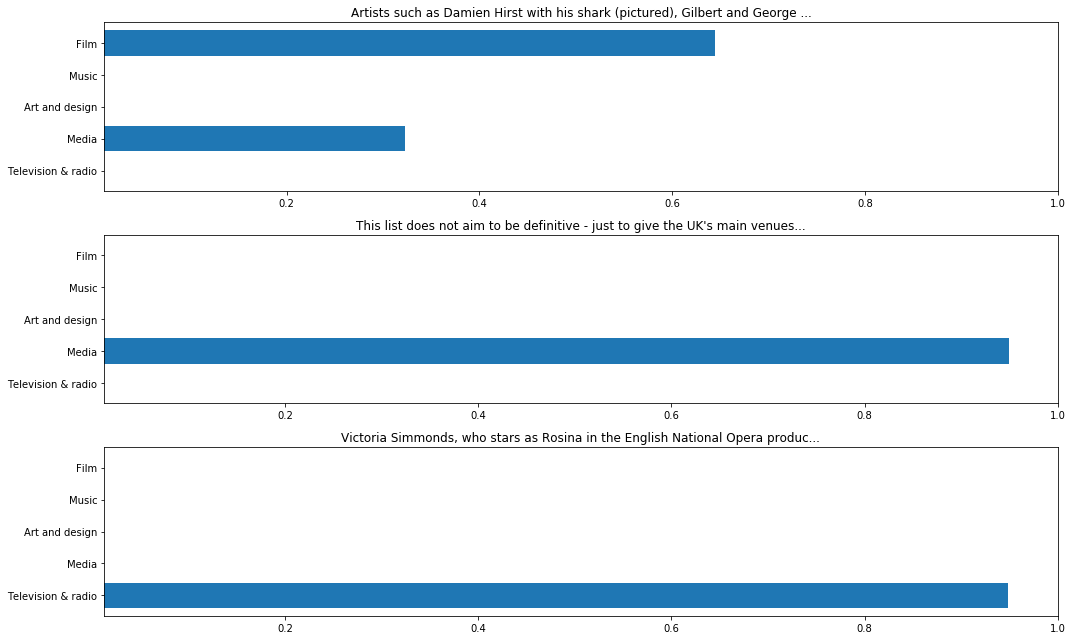

In [86]:
import textwrap
from pprint import pprint

def plot_topic_mixes(article, topic, distribution, ax, topn=5):
    sim = distribution
    y = np.arange(len(sim))  
    w = [t[1] for t in sim.items()]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in sim.items()]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    article = (article[:75] + '...') if len(article) > 75 else article
    ax.set_title(article)
    #fig.clear()

fig, axes = plt.subplots(3, 1, figsize=(15, 9))

for unseen_article, ax in zip(unseen_articles, axes.flatten()):
    top_topic, distribution = rank_headline(unseen_article)
    plot_topic_mixes(unseen_article, top_topic, distribution, ax)
    
fig.tight_layout()
plt.show()